# Lindha Mk. 2 (Feature Selection)
<div>
<img src="../images/tony-stark-buildingmk2.jpg" width="400"/>
</div>

The Mk. 1 was too rudimentary and not sophisticated enough to properly distinguish high price homes from low price homes. We shouldn't be too surprised really: we only included 16 numeric fetaures out the 79 total possible features. We also didn't have any categorical features so our model could not even tell the difference between a good quality house vs a poor quality house.

Since the primary problem of the Mk. 1 was underfitting (from being too simple), the ultimate objective then is to make the model more complicated so that it is sophisticated enough to fit the data properly. Thus, let's begin by adding more features.

In [52]:
# all the good stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# the stars of the show
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score

import joblib

np.set_printoptions(precision=5, threshold = 300)

pd.options.display.max_seq_items = 300
pd.options.display.max_columns = 100
pd.options.display.max_rows = 3000

import PaulBettany as jarvis

In [53]:
# load in datasets
train = pd.read_csv('../data/train.csv', index_col='Id')
total = pd.read_csv('../data/ames-cleaned.csv', index_col='Id')

## Mk 2.1 (Categorical Variables)

In [54]:
# list out the features used in the previous model
old_features = ['Lot Area', 'Overall Qual', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1',
            'Total Bsmt SF', '2nd Flr SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Full Bath', 
            'Half Bath', 'Bedroom AbvGr', 'Fireplaces', 'Garage Area', 'Wood Deck SF', 
            'Open Porch SF']


# new features we want to add in
new_features =  [
                'MS Zoning', 'Neighborhood', 'House Style', 'Roof Matl', 'Exterior 1st', 
                'Mas Vnr Type', 'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 
                'Heating QC','Central Air', 'Kitchen Qual',
                ]

# list comprehension to recover the original ordering of the columns
features = [col for col in total.columns if col in old_features+new_features] 


In [55]:
# create a new project
lindhamk2_1 = jarvis.Project(
                    total[features+['SalePrice']].iloc[:len(train.index)], # training set
                    total[features+['SalePrice']].iloc[len(train.index):], # kaggle submission set
                    target='SalePrice', # target variable name
                    name='LinDHA Mk 2.1' # name of our model
                )

# set random seed
lindhamk2_1.seed = 42

In [56]:
lindhamk2_1.training.shape

(2051, 31)

- We currently have 31 columns: 17 numerical and 14 categorical.
- To do regression on the categorical columns, we will have to convert them into numerics. The 3 most popular ways are:
    - One-hot encoding: creates indicator/dummy variables for each class in a categorical column.
    - Frequency encoding: map each class to the relative frequency of th eclass.
    - Targe/Mean encoding: map each class to the mean value of the target variable across members of that class.
    
We shall do One-Hot Encoding because the number of extra variables isn't too worrisome at the moment (as we still have a relatively small number). We have packaged the One-Hot Encoding into the ```Project.prepare_data()``` method, so perhaps it is worth mentioning: all that is happening under the hood is we are calling ```pd.get_dummies```. The reader may wish to take a look at the ```PaulBettany``` file to convinced themselves this is the case.

In [57]:
# encode dummy variables
lindhamk2_1.prepare_data()

In [58]:
# check the shape of the prepared data and the training data (denoted X)
lindhamk2_1.preparedinputs.shape, lindhamk2_1.X.shape

((2929, 110), (2051, 110))

In [59]:
# attach LinearRegression() model to project
lindhamk2_1.model = LinearRegression()

# preview model with 5-fold cross val
lindhamk2_1.cross_val()

0.8010995349264365

- Well the cross-validation score is 0.01 better than the Mk. 1 but let's build it anyways and see what happens.

In [60]:
# train model on training set
lindhamk2_1.prototype()

 
R2 :0.8939163181385164
MSE: 675021939.0705171
RMSE: 25981.184327711413
MAE: 16221.501930691225
 


In [61]:
# 
lindhamk2_1.grade()

          Train                    Test       
R2:   0.8939163181385164,   0.8960510158605545
MSE:  675021939.0705171,  617614499.8360835
RMSE: 25981.184327711413,   24851.851034401512
MAE:  16221.501930691225,   17028.905818175153


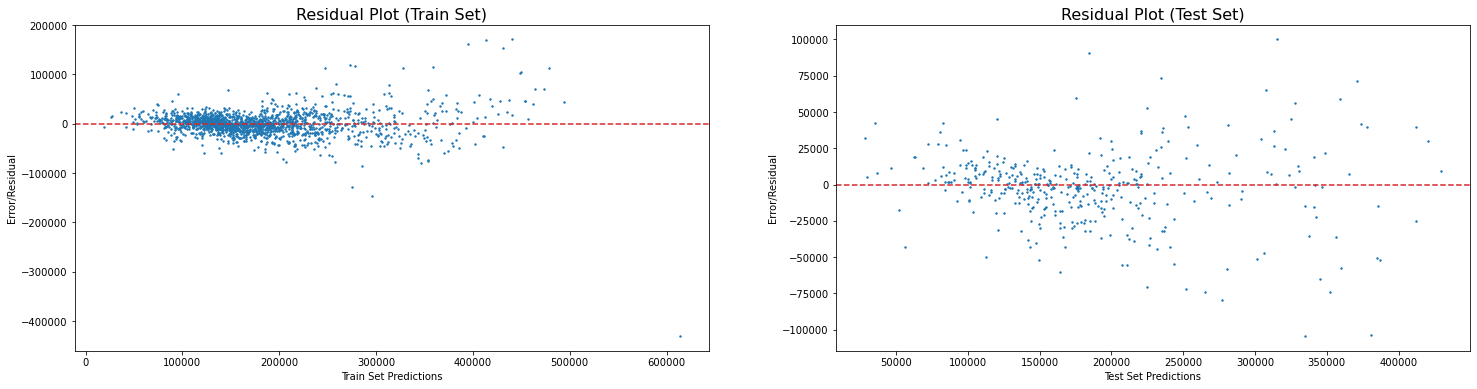

In [62]:
lindhamk2_1.plot_residuals(slice='both', s=2)

<br> 

We seem to have significantly cut down on the underfitting. There is still a hint of it at the right-tail when the Sale Price gets large, but the residuals do look significantly more random and noisy than the Mk. 1 model.

<br>

## Mk 2.2 (Model Tuning in the Feature Space)

There are 2 major things we want to "iron out" with the Mk 2:
1) The underfitting on the right-tail: our model seems to consistenly underpredict high priced homes. Upon closer inspection, we see that there is a high-leverage point on the bottom-right corner. That is, there is a single house that (for some reason) is significantly cheaper than what our model predicts and this is "pulling" the model's predictions down at the expense of accurately predicting the other houses.
2) Heteroskedatistic errors: this is problematic since there are large swings in under vs overestimation as the housing prices get large. From a business perspective, this presents quite a large risk as wrong predictions can cost hundreds-of-thousands of dollars.

Heteroskedasticy of the residuals can probably be dealt with using a log transform on the target variable. The more concerning issue is the high-leverage/outlier point in the training set: do we throw it away to try and fit the other high-end houses, or should we try to get our model to incorporate the outlier point? It would be prudent to explore both options and we shall do so.

First, let's see if we can wrange that high-leverage point by using some more features. There might be a chance that we are missing a key feature to help the model understand why this house is so cheap.

In [63]:
# list out new features to add

# We add in some more numerical features which we originally left out
# due to fears of multicollinearity
new_numfeatures = ['1st Flr SF','TotRms AbvGrd', 'Bsmt Unf SF', 'Screen Porch']

# Some more categorical features we think may help appease the outlier point
# Note that MS SubClass needs to be converted from int64 to an object dtype
new_catfeatures = ['MS SubClass', 'Lot Shape', 'Foundation', 'Overall Cond']


columns = [col for col in train.columns if col in lindhamk2_1.features + new_numfeatures + new_catfeatures]+['SalePrice']


In [64]:
# create a new Project using the columns defined above
lindhamk2_2 = jarvis.Project(total[columns].iloc[:len(train.index)] , total[columns].iloc[len(train.index):] , target = 'SalePrice', name = 'LinDHA Mk 2.2' )

In [65]:
# Convert MS SubClass to non-numerical column
lindhamk2_2.num_to_cat(columns=['MS SubClass'])

In [66]:
# set seed, prepare, encode, train-test-split data
lindhamk2_2.seed = 42

lindhamk2_2.prepare_data()

C:\Users\herma\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [67]:
# check how many new columns we have
lindhamk2_2.X.shape

(2051, 138)

In [68]:
# attach a LinearRegression() object to our project
lindhamk2_2.model = LinearRegression()

# preview 5-fold cv score
lindhamk2_2.cross_val()

0.8208059946142356

- The cross-validation score finally broke the 0.8 barrier, which seems promising.

In [69]:
# build and grade our model
lindhamk2_2.prototype()

lindhamk2_2.grade()

 
R2 :0.9072704324317027
MSE: 590048265.7724296
RMSE: 24290.909117866082
MAE: 15099.410783703564
 
          Train                    Test       
R2:   0.9072704324317027,   0.9156542406317248
MSE:  590048265.7724296,  501141636.12844914
RMSE: 24290.909117866082,   22386.192979791118
MAE:  15099.410783703564,   15615.977822213155


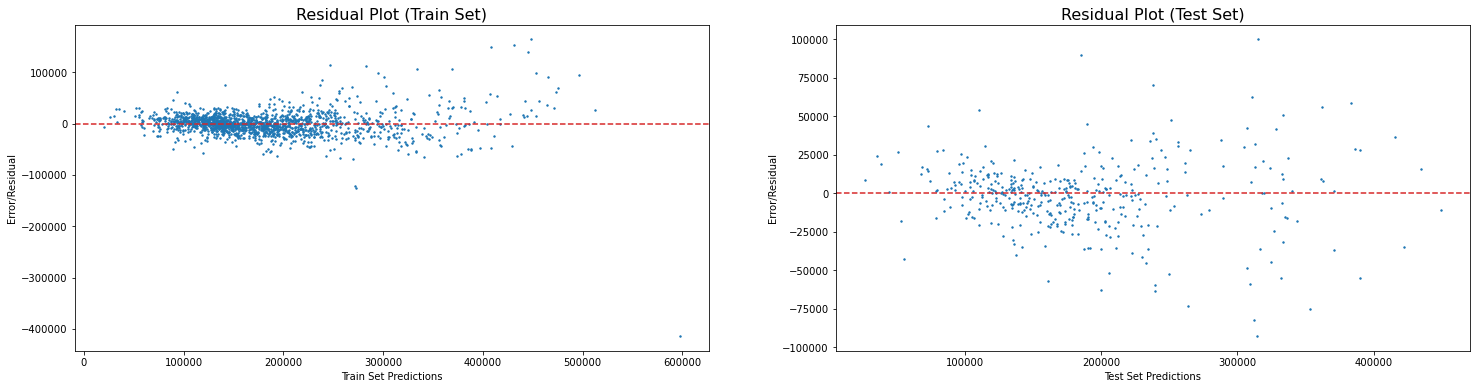

In [70]:
lindhamk2_2.plot_residuals(slice='both', s=2)

<br> 

We still are not able to properly wrangle the outlier point. Let us try dropping it from the training data and see if it helps things.

<br> 

In [71]:
# locate the problem point.
problempoint = 0
for i in range(len(lindhamk2_2.y_trainpred)):
    if lindhamk2_2.y_trainpred[i] > 500_000:
        problempt = i
        print(i)

891
1268


In [72]:
# The problem point is an row 461, let's go find it in the training set
lindhamk2_2.X_train.iloc[[problempt]]

,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Gr Liv Area,Bsmt Full Bath,Full Bath,Half Bath,Bedroom AbvGr,TotRms AbvGrd,Fireplaces,Garage Area,Wood Deck SF,Open Porch SF,Screen Porch,MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,...,Mas Vnr Type_CBlock,Mas Vnr Type_No Feature,Mas Vnr Type_None,Mas Vnr Type_Stone,Exter Qual_Fa,Exter Qual_Gd,Exter Qual_TA,Exter Cond_Fa,Exter Cond_Gd,Exter Cond_Po,Exter Cond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Bsmt Qual_Fa,Bsmt Qual_Gd,Bsmt Qual_No Feature,Bsmt Qual_Po,Bsmt Qual_TA,Bsmt Cond_Fa,Bsmt Cond_Gd,Bsmt Cond_No Feature,Bsmt Cond_Po,Bsmt Cond_TA,Heating QC_Fa,Heating QC_Gd,Heating QC_Po,Heating QC_TA,Central Air_Y,Kitchen Qual_Fa,Kitchen Qual_Gd,Kitchen Qual_Po,Kitchen Qual_TA,MS SubClass_30,MS SubClass_40,MS SubClass_45,MS SubClass_50,MS SubClass_60,MS SubClass_70,MS SubClass_75,MS SubClass_80,MS SubClass_85,MS SubClass_90,MS SubClass_120,MS SubClass_150,MS SubClass_160,MS SubClass_180,MS SubClass_190
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2181,39290.0,10.0,5.0,2008.0,2009.0,1224.0,4010.0,1085.0,5095.0,5095.0,0.0,5095.0,1.0,2.0,1.0,2.0,15.0,2.0,1154.0,546.0,484.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<br> 

A manual inspection of House 2181 doesn't reveal anything out of the ordinary: the is large, built from high quality material, functional, and in decent condition. In fact, we are inclined to agree with our model that this house should not be worth so little.


## Mk 2.3 (Dropping the High-Leverage Point)

Let us drop House 2181 and see if the model can better predict the high-priced homes.

In [73]:
total.drop(index=[2181], inplace=True)

In [74]:
lindhamk2_3 = jarvis.Project(
                        total[columns].iloc[ : len(train.index)-1 ], # we have to subtract 1 because we dropped a row
                        total[columns].iloc[len(train.index)-1 : ],
                        target = 'SalePrice',
                        name = 'LinDHA Mk 2.3'
                )

lindhamk2_3.num_to_cat(columns=['MS SubClass'])

In [75]:
# make sure we haven't touched the kaggle submission set with the drop.
lindhamk2_3.training.shape, lindhamk2_3.y.shape, lindhamk2_3.unknown.shape

((2050, 39), (2050,), (878, 39))

In [76]:
# attach model, prepare data, and preview cv-score
lindhamk2_3.model = LinearRegression()

lindhamk2_3.seed = 42

lindhamk2_3.prepare_data()

lindhamk2_3.cross_val()

C:\Users\herma\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


0.7981721575447148

In [77]:
# build the model
lindhamk2_3.prototype()

 
R2 :0.9282083771782362
MSE: 449137071.5563989
RMSE: 21192.854256951774
MAE: 14368.913637297015
 


In [78]:
lindhamk2_3.grade()

          Train                    Test       
R2:   0.9282083771782362,   0.9260184518942671
MSE:  449137071.5563989,  472232747.50452226
RMSE: 21192.854256951774,   21730.916858350047
MAE:  14368.913637297015,   15661.962384593406


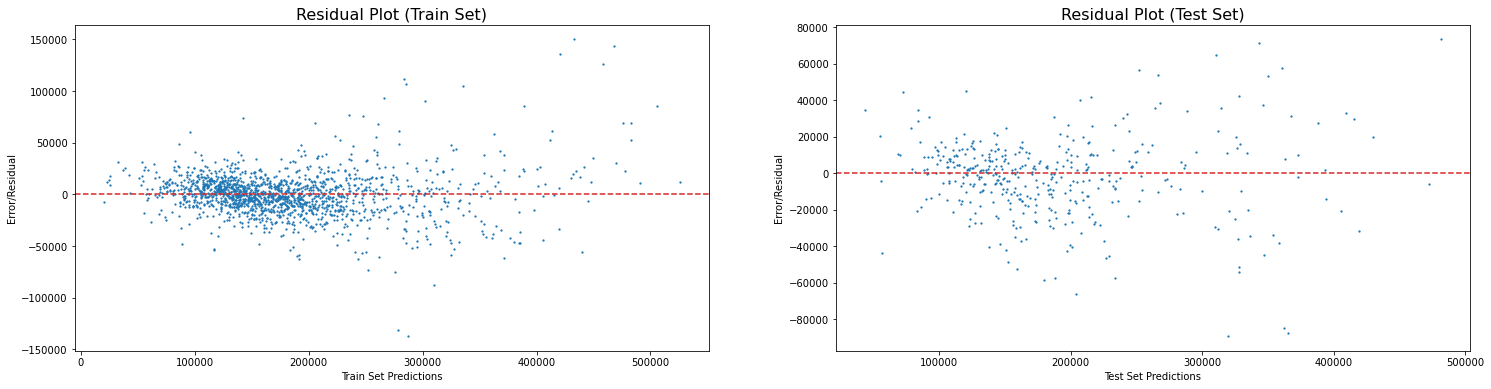

In [79]:
lindhamk2_3.plot_residuals(slice='both')

<br> 

Dropping the outlier seems to have slightly improved the scores on the test. Let's keep this change for now.

<br>

## Finalized Mk 2 Model

The author tried out various other parameter configurations for the Mk 2 (the interested reader may check the archive folder to view the some of these attempts). We compile the final resulting configuration that seems to have provided the best results on the test set.

In [80]:
new_features = ['Pool QC', 'Roof Mtl', 'Utilities']

columns = [ col for col in total.columns if col in lindhamk2_2.features + new_features + ['SalePrice'] ]


In [81]:
lindhamk2_4 = jarvis.Project(
                        total[columns].iloc[ : len(train.index) - 1],
                        total[columns].iloc[ len(train.index) - 1 : ],
                        target = 'SalePrice',
                        name = 'LinDHA Mk 2.4'
                )

In [82]:
lindhamk2_4.training.shape, lindhamk2_4.unknown.shape, lindhamk2_4.y.shape

((2050, 41), (878, 41), (2050,))

In [83]:
lindhamk2_4.num_to_cat(columns=['MS SubClass'])

In [84]:
lindhamk2_4.model = LinearRegression()

lindhamk2_4.seed = 42

lindhamk2_4.prepare_data()

lindhamk2_4.cross_val()

C:\Users\herma\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


0.7934145408550742

In [85]:
lindhamk2_4.prototype()

 
R2 :0.9287464623046452
MSE: 445770745.9542688
RMSE: 21113.283637422883
MAE: 14314.584912967912
 


In [86]:
lindhamk2_4.grade()

          Train                    Test       
R2:   0.9287464623046452,   0.9261245120562674
MSE:  445770745.9542688,  471555753.26765347
RMSE: 21113.283637422883,   21715.33451889824
MAE:  14314.584912967912,   15640.919077249635


The Mk 2.4 model seems to be about as good as we can tune it via manual search. The train and test scores are near identical and any more tuning runs the risk of overfitting.

Since we are happy with this under-overfit balance, let's train it over all examples, make predictions for the kaggle set, and save it as a .pkl file.

In [87]:
lindhamk2_4.name = 'LinDHA Mk 2 final'

In [88]:
lindhamk2_4.build_model()

In [90]:
len(lindhamk2_4.features), len(lindhamk2_4.numericals), len(lindhamk2_4.categoricals)

(40, 22, 18)

In [91]:
# Now let's also demonstrate how the Project object can  be used to organize and prepare kaggle submissions
lindhamk2_4.prepare_submissions()

C:\Users\herma\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
C:\Users\herma\desktop\GA_DSI\projects\project-2\code\PaulBettany.py:663: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.submissions[self.target] = self.model.predict(self.X_unknown)


In [92]:
lindhamk2_4.submissions['SalePrice']

Id
2658    157386.885320
2718    153677.565258
2414    201311.370724
1989    101314.612020
625     175097.109786
333      80781.954944
1327    103089.740599
858     149493.717285
95      176220.881941
1568    169969.031791
2482    131839.696084
1364    123724.751547
2584    144083.835310
818     274519.055064
2673    139990.638394
2089    127646.019115
1297    135489.257884
790     114865.231261
2616    203132.125780
720     167973.910567
222     153120.885571
557     128557.371233
1148    174673.680530
2766   -506961.300962
534     182031.616368
1452    117899.184795
630     108503.099190
2648    124563.418412
125     157827.304300
1904     59825.861797
1670    106073.331281
756      82217.786962
717     214917.901697
1032    151124.781593
852     212797.088984
1731    177425.125980
2639    121823.148123
2071     97857.009667
1267    105595.004353
1851    204630.131859
567     147926.873981
2439    200467.133664
1898    147509.795088
647     160799.948226
2256    200238.701437
979    

- NOTICE: there are a 2 houses with a severly negative value. This is a huge issue since it seems these houses must have some kind of rare features that just happen to correspond to negative parameters in the model.

- This did not happen in the training set or the test set, so we are led to believe that whatever is going on must be some kind of class inbalance between our training data and the kaggle submission data: some of the houses in the submission set have features that are rare amongst our training set and our model does not know how to properly appraise these houses.

- We'll have to manually fix it by setting the negative house prices to 0.

In [93]:
lindhamk2_4.submissions[ lindhamk2_4.submissions['SalePrice'] < 0 ] 

,SalePrice
Id,
2766,-506961.300962
1908,-523770.881531


In [94]:
lindhamk2_4.submissions[ lindhamk2_4.submissions['SalePrice'] < 0 ] = 0

C:\Users\herma\AppData\Local\Temp\ipykernel_18316\3073083528.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lindhamk2_4.submissions[ lindhamk2_4.submissions['SalePrice'] < 0 ] = 0
C:\Users\herma\AppData\Local\Temp\ipykernel_18316\3073083528.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lindhamk2_4.submissions[ lindhamk2_4.submissions['SalePrice'] < 0 ] = 0


In [95]:
lindhamk2_4.submissions[ lindhamk2_4.submissions['SalePrice'] < 0 ] 

,SalePrice
Id,


In [96]:
lindhamk2_4.submissions.to_csv('../data/lindhamk2-submission.csv')

In [97]:
# save our work
lindhamk2_4.save(csv=False, pkl=True, pkl_path = '../saved-files/lindhamk2-final.pkl')